# Tutorial 7: Ocean heat content

### Week 1, Day 2: State of the Climate - Ocean and Atmospheric Reanalysis

***
## Tutorial objectives
This tutorial focuses on heat content in the ocean. We aim to understand the spatial structure of heat and how heat content is changing in time.

***
## Set up
Here we import needed packages, and import ECCO data that has been preprocessed.
NOTE: Here working with interpolated data fields to lat-lon grid

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter 
import cmocean

In [ ]:
#Import preprocessed ecco data. This data is full depth temperature data over 1992 to 2016 (annual mean)
A= xr.open_dataset("theta_annual_mean.nc")
A=A.THETA
A=A.where(A != 0) #make land points equal to NaN

## Section 1: Where in the vertical is ocean heat located? 

In [ ]:
#First let's take the mean over the period 1992 to 1994
subset_theta=A.sel(year=slice('1992', '1994')).mean('year')

Text(0.5, 1.0, 'Global zonal mean of temperature (C)')

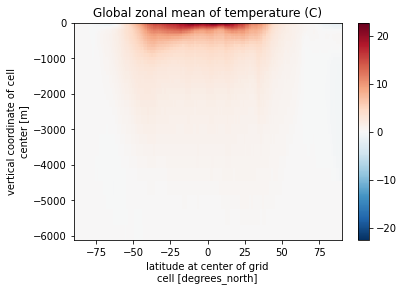

In [ ]:
#Let's plot a zonal mean slice of this data. We take a mean just in longitudes by dividing the dA coordinate by the 
(((subset_theta-273.15)*subset_theta.dX).sum('longitude')/(subset_theta.dX.sum('longitude'))).plot()
plt.title('Global zonal mean of temperature (C)')

We see that temperature is warmer near the surface. Now let's explore what this means for heat content! Let's now look at where heat is stored. Heat is measured in Joules which is equivalent to kg$*$m$^2$/s$^2$. The heat content down to a certain depth $z_1$ up to the surface (height of 0) is a volume integral (over dimensions x,y,z). It can be written as:
$$\iiint_{z_1}^0 c_p*\rho_0*\theta(x,y,z) dz dA$$
if we here use $dA$ for the area integral (double integral) over the x and y (lat, lon) coordinates. $\rho_0$ is the reference density in units of kg/m$^3$ and $c_p$ is specific heat capacity in units of J/(kg$*$K)

In [ ]:
theta_area_int=(subset_theta*A.dA).sum('latitude').sum('longitude') #we take an area integral first at each depth level

Text(0.5, 1.0, 'Where heat is stored by depth')

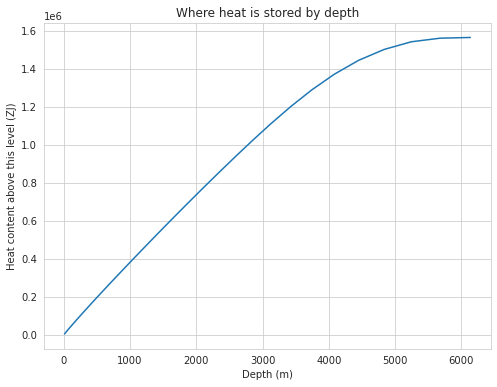

In [ ]:
rho = 1026 #kg/m^3
c_p = 3990 #J/(kg K)

sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(-A.Zu,(rho*c_p*theta_area_int*A.dZ).cumsum()/10**21)
plt.xlabel('Depth (m)')
plt.ylabel('Heat content above this level (ZJ)')
plt.title('Where heat is stored by depth')

We see that more heat is held in the upper ocean than the lower ocean. This correlates with what we saw with the zonal mean plotting that it is warmer in the upper ocean. Assume the ocean is around 6000 meters deep. Reading off this graph, what percentage of heat is held in the third of the ocean (top 2000 meters)?

## Section 2: How is heat changing in time?

Let's look at the integral of heat, full depth and down to individual levels over time

In [ ]:
#theta_clim = A.groupby('time.month').mean(dim='time') #seasonal cycle
#theta_anom = A.groupby('time.month') - theta_clim #get rid of seasonal cycle


rho = 1026 #kg/m^3
c_p = 3990 #J/(kg K)
global_heat=rho*c_p*((A*A.dZ*A.dA).sum('Z').sum('latitude').sum('longitude'))
global_heat_upper2000=rho*c_p*((A.where(-A.Zu<2000)*A.dZ*A.dA).sum('Z').sum('latitude').sum('longitude'))
global_heat_upper700=rho*c_p*((A.where(-A.Zu<700)*A.dZ*A.dA).sum('Z').sum('latitude').sum('longitude'))

heat_anom_fulldepth=global_heat-global_heat[0:5].mean() #remove first 5 year mean
heat_anom_upper2000=global_heat_upper2000-global_heat_upper2000[0:5].mean()
heat_anom_upper700=global_heat_upper700-global_heat_upper700[0:5].mean()


Text(0.5, 1.0, 'Change in heat over time')

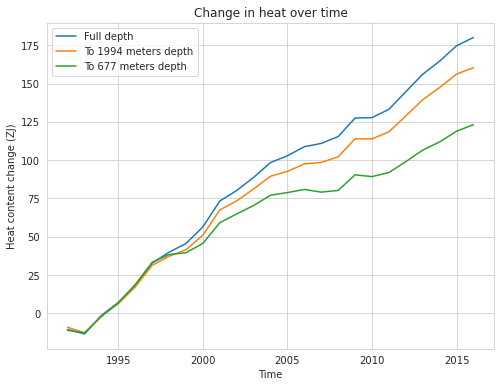

In [ ]:
#this cell may take a while to run!

fig,ax = plt.subplots(figsize=(8,6))
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
plt.plot(global_heat.year,heat_anom_fulldepth/10**21)
plt.plot(global_heat.year,heat_anom_upper2000/10**21)
plt.plot(global_heat.year,heat_anom_upper700/10**21)
plt.xlabel('Time')
plt.ylabel('Heat content change (ZJ)')
plt.legend(['Full depth','To 1994 meters depth','To 677 meters depth'])
plt.title('Change in heat over time')

We see that most heat gain is in the upper ocean - the change in the top 2000 meters is nearly equal to the full depth change. Based on this graph, what percentage of additional heat since 1992 is stored in the top 2000 meters?

## Section 3: Spatial locations of heat

First, let's look at where heat is stored typically. We plot this below and see the lower latitudes have more heat content than the higher latitudes

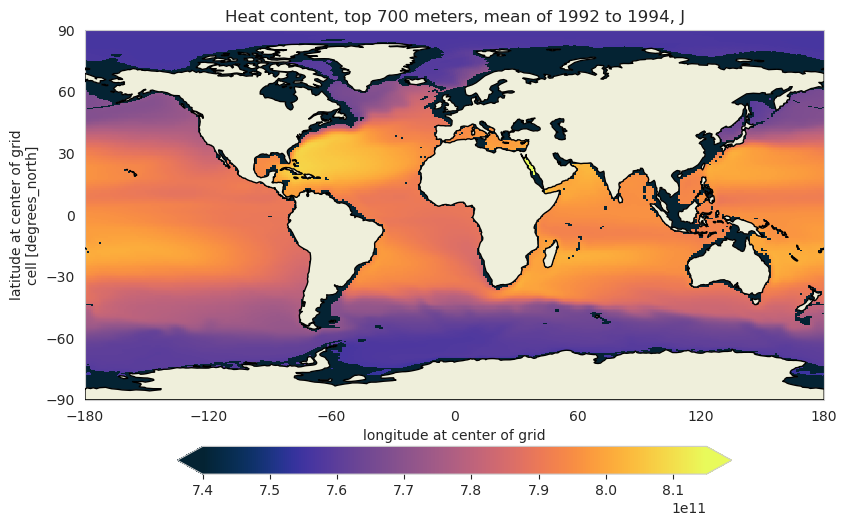

In [ ]:
#First let's plot where heat is stored in the mean
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(((rho*c_p*subset_theta.where(-subset_theta.Zu<700)*subset_theta.dZ).sum('Z'))).plot(vmin=7.4E11,vmax=8.15E11,cmap=cmocean.cm.thermal,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Heat content, top 700 meters, mean of 1992 to 1994, J')
fig.tight_layout()

Now let's look at the spatial pattern of heat gain over 1992 to 2016

In [ ]:
#We already defined an object that's the mean over years 1992 to 1994 (subset_theta). Now define an object that's mean over 2014 to 2016
subset_theta_future=A.sel(year=slice('2014', '2016')).mean('year')

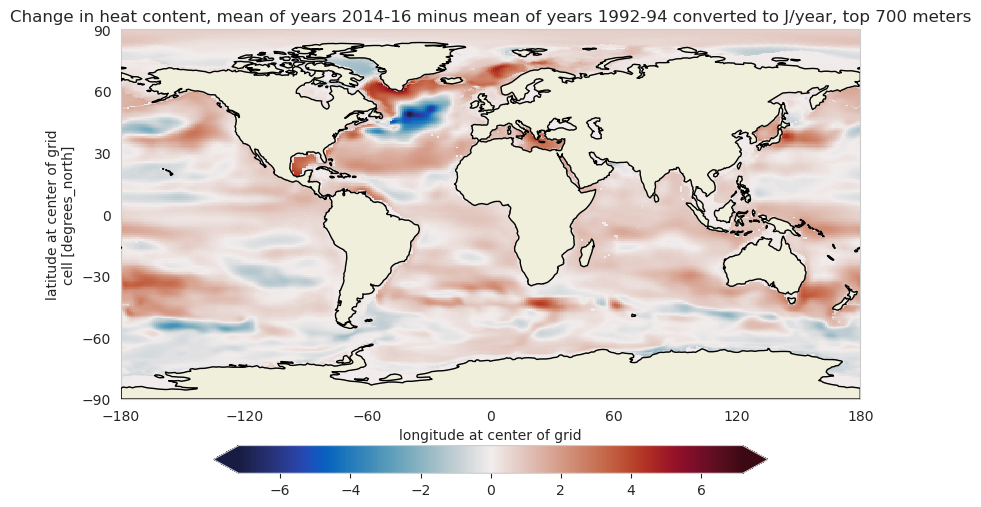

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(((rho*c_p*subset_theta_future.where(-subset_theta_future.Zu<700)*subset_theta_future.dZ).sum('Z')-(rho*c_p*subset_theta.where(-subset_theta_future.Zu<700)*subset_theta.dZ).sum('Z'))/(24*60*60*365*(2015-1993))).plot(cmap=cmocean.cm.balance,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Change in heat content, mean of years 2014-16 minus mean of years 1992-94 converted to J/year, top 700 meters')
fig.tight_layout()
#can be compared to plot on ecco website for top 200 meters, https://www.ecco-group.org/ohc.htm

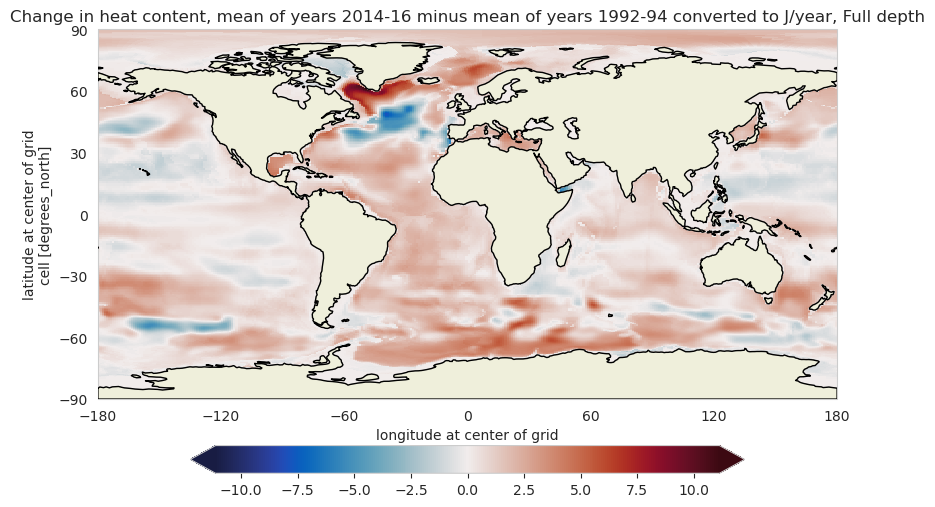

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(((rho*c_p*subset_theta_future*subset_theta_future.dZ).sum('Z')-(rho*c_p*subset_theta*subset_theta.dZ).sum('Z'))/(24*60*60*365*(2015-1993))).plot(cmap=cmocean.cm.balance,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Change in heat content, mean of years 2014-16 minus mean of years 1992-94 converted to J/year, Full depth')
fig.tight_layout()

We see heat gain isn't spatially uniform. Comparing the two plots, we again see that most heat gain is in the upper ocean